In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.patches import Rectangle, Circle
from skimage import io

# general libraries
import os  
import sys
import json
import time
import h5py as h5
from functools import partial

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf
from scalebars import *
import deconv

# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
sys.path.append('../imaging-utils')
from image_arrays import map_axis

In [2]:
# %matplotlib notebook
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/offset_ds_extras/"
data_path = os.path.join(base_path, "velocity_5tr_2018_11_07")
fig_path = os.path.join(base_path, "figs")
exts = [".png", ".svg"]

os.makedirs(fig_path, exist_ok=True)
vels = np.array(sorted([int(v[1:]) for v in os.listdir(data_path)]))
cond_keys = os.listdir(os.path.join(data_path, "v%i" % vels[0]))
cond_lbls = ["ratio & timing", "ratio", "timing"]
cond_long_lbls = map(lambda s: "asymmetric %s" % s, cond_lbls)
cond_to_lbl = {k: lbl for k, lbl in zip(cond_keys, cond_lbls)}
cond_to_long_lbl = {k: lbl for k, lbl in zip(cond_keys, cond_long_lbls)}

dt = 0.1

vm_recs, spk_idxs, spk_counts, spk_times = {}, {}, {}, {}
for cond in cond_keys:
    vel_vms = []
    for vel in vels:
        vk = "v%i" % vel
        vm = np.loadtxt(os.path.join(data_path, vk, cond, "Vm.dat")).T.reshape(5, 8, -1)
        vel_vms.append(vm)
    vm_recs[cond] = np.stack(vel_vms, axis=0)
    spk_idxs[cond] = [
        [[signal.find_peaks(r, height=20)[0] for r in ds] for ds in ts]
        for ts in vm_recs[cond]
    ]
    spk_times[cond] = [
        [[r * dt for r in ds] for ds in ts]
        for ts in spk_idxs[cond]
    ]
    spk_counts[cond] = np.array([
        [[len(r) for r in ds] for ds in ts]
        for ts in spk_idxs[cond]
    ])

vm_xaxis = np.arange(vm_recs[cond_keys[0]].shape[-1]) * dt
n_vels, n_trials, n_dirs, n_pts = vm_recs[cond_keys[0]].shape
print("cond_keys:", cond_keys)
print("velocities:", vels)
print("vm rec shape (vels, trials, dirs, time):", vm_recs[cond_keys[0]].shape)

cond_keys: ['dirPi_dirOff', 'dirPi_noOff', 'nonDirPi_dirOff']
velocities: [ 500 1000 1500 2000 4000]
vm rec shape (vels, trials, dirs, time): (5, 5, 8, 7501)


In [4]:
dir_labels = np.array([225, 270, 315, 0, 45, 90, 135, 180])
circle = np.radians([0, 45, 90, 135, 180, 225, 270, 315, 0])
dir_rads = np.radians(dir_labels)
dirs_180 = np.array([ana.scale_180_from_360(d) for d in dir_labels])

In [5]:
# these currents might actually be for 500um/s recorded at 2kHz (rather than 1000um at 1kHz)
# offsets roughly line up with SR spiking if treated as 1kHz, but currents are far too long to be in response
# to a 1000um sweep
dir_avg_exc = np.loadtxt("/mnt/Data/PhDwork/EI_Offset/dirPi_dirOff/currents/dirAvgExc.dat").T
dir_avg_ach = np.loadtxt("/mnt/Data/PhDwork/EI_Offset/dirPi_dirOff/currents/dirAvgACH.dat").T
dir_avg_nonds_gaba = np.loadtxt("/mnt/Data/PhDwork/EI_Offset/nonDirPi_dirOff/currents/dirAvgInh.dat").T
vc_xaxis = np.arange(dir_avg_ach.shape[-1]) * 0.5
print("current shape:", dir_avg_exc.shape)

current shape: (8, 901)


v1000 VC offsets (ms): [142, 147, 178, 206, 181, 151, 133, 149]
v1000 VC alignment offsets (ms): [64 59 28  0 25 55 73 57]


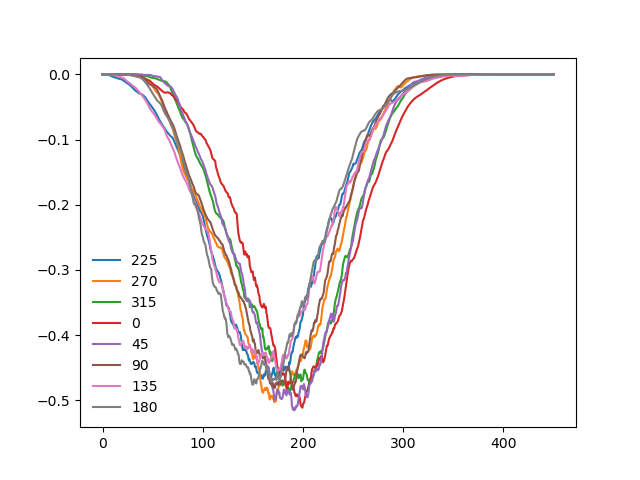

In [6]:
thresh = -0.15
thresh = -0.1
# thresh = -0.05
v1000_vc_offsets = []
dir_avg_epsc_fig, dir_avg_epsc_ax = plt.subplots(1)
for d in range(n_dirs):
    dir_avg_epsc_ax.plot(vc_xaxis, dir_avg_ach[d], label=dir_labels[d])
    v1000_vc_offsets.append(np.where(dir_avg_ach[d] < thresh)[0][0])

dir_avg_epsc_ax.legend(frameon=False)
print("v1000 VC offsets (ms):", v1000_vc_offsets)
align_v1000_vc_offsets = np.max(v1000_vc_offsets) - v1000_vc_offsets
print("v1000 VC alignment offsets (ms):", align_v1000_vc_offsets)

v1000 SR offsets (ms): [40.400000000000006, 51.800000000000004, 82.2, 94.80000000000001, 79.4, 52.0, 42.5, 51.5]
v1000 SR alignment offsets (ms): [54.4 43.  12.6  0.  15.4 42.8 52.3 43.3]


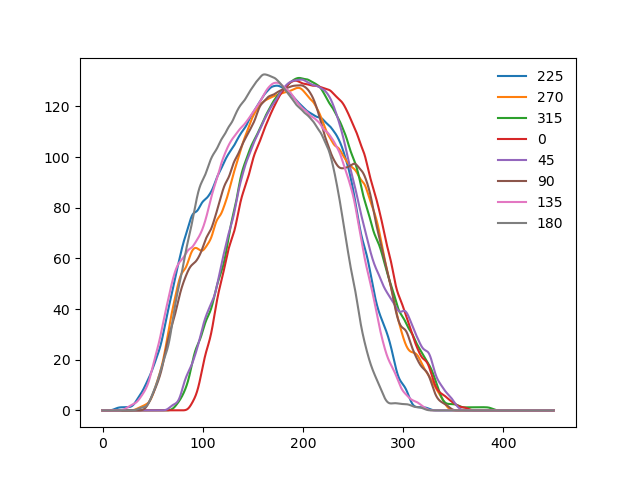

In [7]:
sr_rate_thresh = 8
offset_sr_vm = np.loadtxt("/mnt/Data/PhDwork/EI_Offset/dirOff_SR/Vm.dat").T.reshape(20, 8, -1)
offset_sr_rates = spike_transform(offset_sr_vm, 3000, 30).mean(axis=0) * 100
offset_sr_rates = rolling_average(offset_sr_rates, n=300)
offset_sr_xaxis = np.arange(offset_sr_rates.shape[-1]) * dt

v1000_sr_offsets = []
dir_sr_rates_fig, dir_sr_rates_ax = plt.subplots(1)
for d in range(n_dirs):
    dir_sr_rates_ax.plot(offset_sr_xaxis, offset_sr_rates[d], label=dir_labels[d])
    v1000_sr_offsets.append(np.where(offset_sr_rates[d] > sr_rate_thresh)[0][0] * dt)

dir_sr_rates_ax.legend(frameon=False)
print("v1000 SR offsets (ms):", v1000_sr_offsets)
align_v1000_sr_offsets = np.max(v1000_sr_offsets) - v1000_sr_offsets
print("v1000 SR alignment offsets (ms):", align_v1000_sr_offsets)

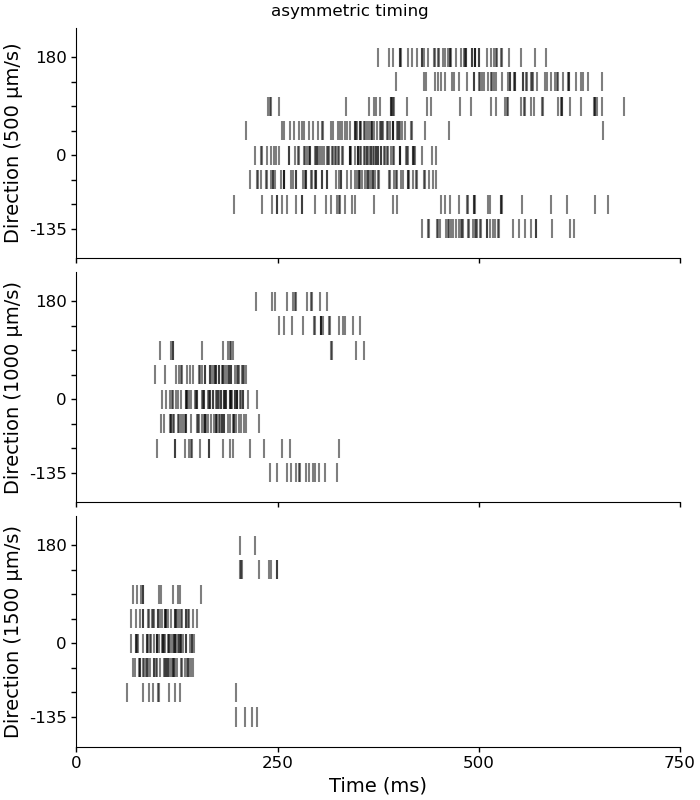

In [8]:
vel_idxs = [0, 1, 2]
# cond = "dirPi_dirOff"
# cond = "dirPi_noOff" 
cond = "nonDirPi_dirOff"
alignment_mode = "SR"  # "manual", "VC", "SR", "none"

if alignment_mode == "manual":
    alignment_shifts = np.array([59, 64, 24, 0, 20, 56, 68, 61]) # vel 1000 (thresh -0.15)
    # alignment_shifts = np.array([63, 59, 30, 0, 23, 53, 65, 68]) # vel 1000 (thresh -0.2)
elif alignment_mode == "VC":
    alignment_shifts = align_v1000_vc_offsets
elif alignment_mode == "SR":  # SR
    alignment_shifts = align_v1000_sr_offsets
else:
    alignment_shifts = np.zeros(n_dirs)
    
vshifts = np.array([m * alignment_shifts for m in (1000 / vels)])
# vshifts = np.zeros_like(vshifts)

raster_fig, raster_ax = plt.subplots(len(vel_idxs), sharex=True, figsize=(7, 8))
for vi, ax in zip(vel_idxs, raster_ax):
    dir_ts = [
        [tm + vshifts[vi][d] for t in range(n_trials) for tm in spk_times[cond][vi][t][d]]
        for d in range(n_dirs)
    ]
    ax.eventplot(
        dir_ts,
        lineoffsets=dirs_180,
        linelengths=35,
        colors="black",
        alpha=0.5,
    )
    ax.set_yticks(dirs_180)
    ax.set_yticklabels([-135, None, None, 0, None, None, None, 180])
    ax.set_ylabel("Direction (%i µm/s)" % vels[vi], fontsize="14")
    # dummy_yaxis_label(ax, "%i µm/s" % vels[vi], offset=-0.12)

raster_ax[-1].set_xlim(0, 750)
raster_ax[-1].set_xticks([0, 250, 500, 750])
raster_ax[-1].set_xlabel("Time (ms)", fontsize="14")
raster_fig.suptitle(cond_to_long_lbl[cond])
clean_axes(raster_ax, ticksize=12)
raster_fig.set_layout_engine("compressed")

vels_lbl = "_".join(map(lambda v: "v%i" % v, vels[vel_idxs]))
for ext in exts:
    raster_fig.savefig(os.path.join(fig_path, "rasters_%s_%s%s" % (cond, vels_lbl, ext)), bbox_inches="tight")

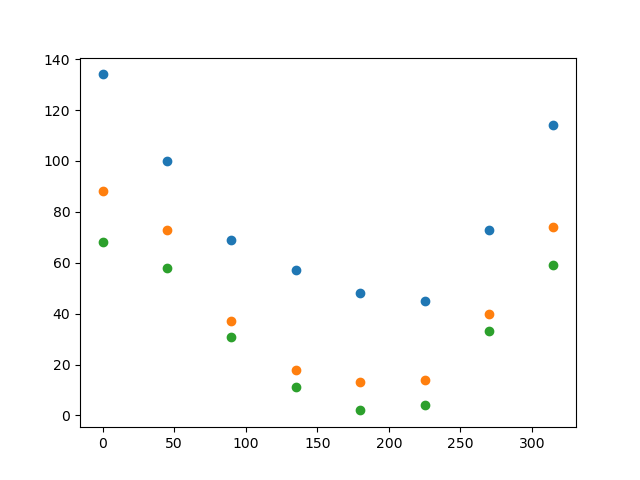

In [9]:
tuning_fig, tuning_ax = plt.subplots(1)
tuning_ax.scatter(dir_labels, spk_counts[cond_keys[0]][0].sum(axis=0))
tuning_ax.scatter(dir_labels, spk_counts[cond_keys[0]][1].sum(axis=0))
tuning_ax.scatter(dir_labels, spk_counts[cond_keys[0]][2].sum(axis=0))

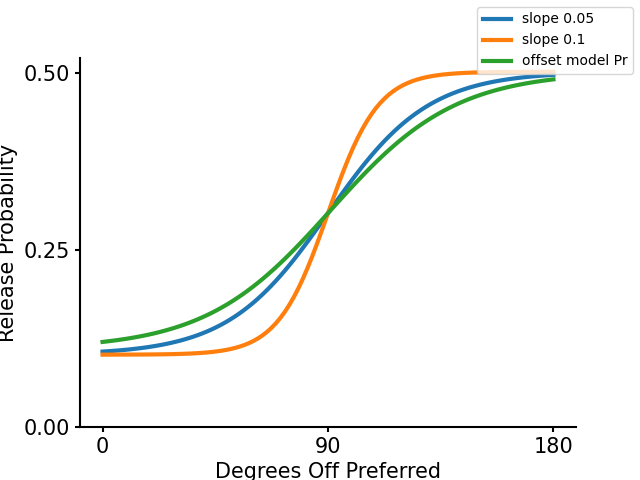

In [15]:
def sigmoid(d, n, p, offset=90, slope=0.075): 
    return p + (n - p) * (1 - 1 / (1 + np.exp((d - offset) * slope)))

def pr_sigmoid(d, n, p, offset=91, slope=(1 / 25)): 
    return p + (n - p) * (1 - 0.98 / (1 + np.exp((d - offset) * slope)))

def offset_sigmoid(d, n, p, offset=74.69, slope=(1 / 24.36)): 
    return p - (p - n) * (1 - 0.98 / (1 + np.exp((d - offset) * slope)))

null_pr = 0.5025
pref_pr = 0.1025
null_off = -58
pref_off = 4

dir_range = np.linspace(0, 180, 100) 
prob_p05 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr, offset=90, slope=0.05))
prob_p1 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr, offset=90, slope=0.1))
pr_sig = np.squeeze(pr_sigmoid(dir_range, null_pr, pref_pr))
off_sig = np.squeeze(offset_sigmoid(dir_range, null_off, pref_off))

sigmoid_fig, sigmoid_ax = plt.subplots(1)
sigmoid_ax.plot(dir_range, prob_p05, linewidth=3, label="slope 0.05")
sigmoid_ax.plot(dir_range, prob_p1, linewidth=3, label="slope 0.1")
sigmoid_ax.plot(dir_range, pr_sig, linewidth=3, label="offset model Pr")
sigmoid_ax.set_ylabel("Release Probability", fontsize=15)
sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
# sigmoid_ax.set_yticks([0, 0.5, 1])
sigmoid_ax.set_yticks([0, 0.25, 0.5])
sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(sigmoid_ax, ticksize=15, spine_width=1.5)
sigmoid_fig.legend()

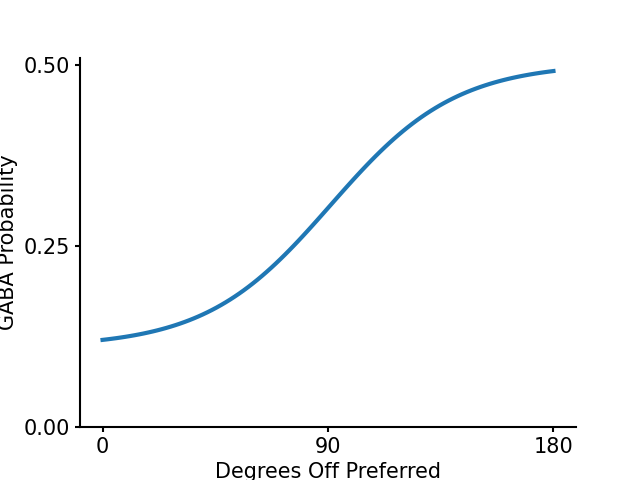

In [11]:
gaba_sigmoid_fig, gaba_sigmoid_ax = plt.subplots(1)
gaba_sigmoid_ax.plot(dir_range, pr_sig, linewidth=3)
gaba_sigmoid_ax.set_ylabel("GABA Probability", fontsize=15)
gaba_sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
clean_axes(gaba_sigmoid_ax, ticksize=15)
# gaba_sigmoid_ax.set_yticks([0, 0.5, 1])
gaba_sigmoid_ax.set_yticks([0, 0.25, 0.5])
gaba_sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(gaba_sigmoid_ax, ticksize=15, spine_width=1.5, tick_width=1.5)
gaba_sigmoid_fig.savefig(os.path.join(fig_path, "gaba_sigmoid.svg"), bbox_inches="tight")

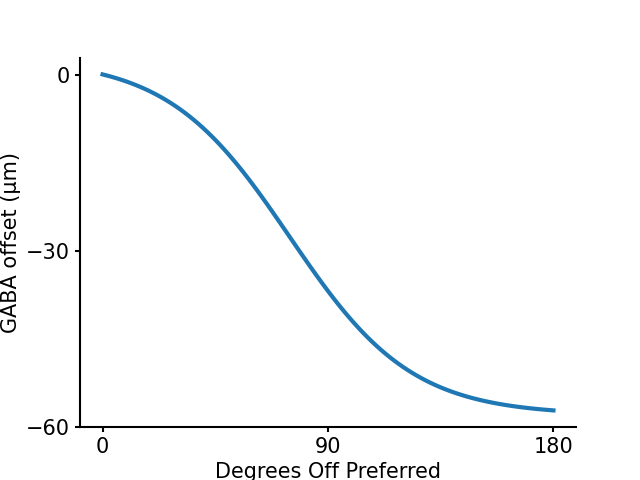

In [12]:
offset_sigmoid_fig, offset_sigmoid_ax = plt.subplots(1)
offset_sigmoid_ax.plot(dir_range, off_sig, linewidth=3)
offset_sigmoid_ax.set_ylabel("GABA offset (µm)", fontsize=15)
offset_sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
clean_axes(offset_sigmoid_ax, ticksize=15)
offset_sigmoid_ax.set_yticks([-60, -30, 0])
offset_sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(offset_sigmoid_ax, ticksize=15, spine_width=1.5, tick_width=1.5)
offset_sigmoid_fig.savefig(os.path.join(fig_path, "offset_sigmoid.svg"), bbox_inches="tight")

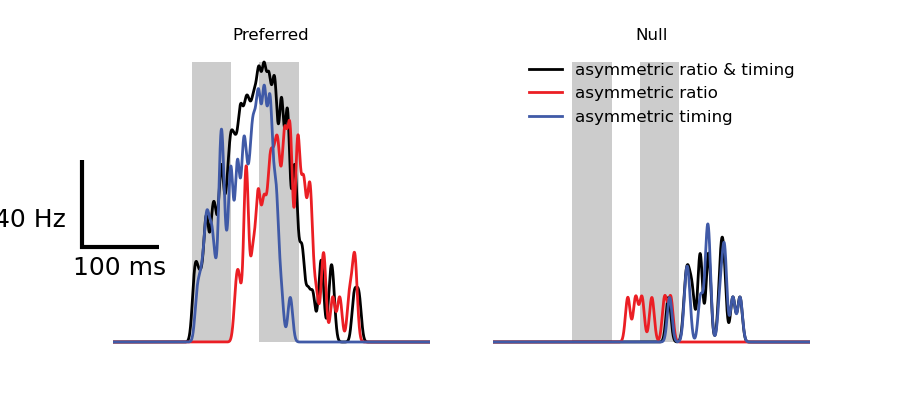

In [13]:
vel_idx = 1
pref_idx = 3
null_idx = 7

pref_rates = {
    cond: spike_transform(vm[vel_idx, :, pref_idx], 3000, 30).mean(axis=0) * 100
    for cond, vm in vm_recs.items()
}
null_rates = {
    cond: spike_transform(vm[vel_idx, :, null_idx], 3000, 30).mean(axis=0) * 100
    for cond, vm in vm_recs.items()
}
pad = int(vshifts[vel_idx, null_idx] / dt)
null_rates = {c: np.r_[np.zeros(pad), r[:-pad]] for c, r in null_rates.items()}
max_rate = max(map(np.max, pref_rates.values()))

timing_blue = "#405aa7ff"
ratio_red = "#eb1e24ff"
cond_to_clr = {cond: clr for cond, clr in zip(cond_keys, ["black", ratio_red, timing_blue])}
win_starts = [100, 185]
# win_starts = [100, 165]
win_dur = 50

pref_null_rate_fig, pref_null_rate_ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4))
for cond in cond_keys:
    lbl, clr = cond_to_long_lbl[cond], cond_to_clr[cond]
    pref_null_rate_ax[0].plot(vm_xaxis, pref_rates[cond], c=clr, linewidth=2, label=lbl)
    pref_null_rate_ax[1].plot(vm_xaxis, null_rates[cond], c=clr, linewidth=2, label=lbl)
for ax in pref_null_rate_ax:
    for start in win_starts:
        ax.add_patch(
            Rectangle(
                (start, 0),
                win_dur, 
                max_rate, 
                fill=True,
                color="black",
                alpha=0.2,
                linewidth=0,
                linestyle="-"
            )
        )
    ax.set_xlim(0, 400)
    # ax.set_xticks([0, 200, 400])
    # ax.set_xlabel("Time (ms)", fontsize=14)

add_scalebar(
    pref_null_rate_ax[0], 
    matchx=False, 
    matchy=False, 
    # sizey=1.5, 
    # labely="1.5 nA",
    sizex=100,
    sizey=40, 
    labelx="100 ms",
    labely="40 Hz",
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(80, 180),
    textprops={"fontsize": 18},
)
pref_null_rate_ax[0].set_title("Preferred")
pref_null_rate_ax[1].set_title("Null")
pref_null_rate_ax[0].set_ylabel("Spike Rate (Hz)", fontsize=14)
pref_null_rate_ax[1].legend(frameon=False, fontsize=12)
clean_axes(pref_null_rate_ax, remove_spines=["top", "bottom", "left", "right"])
# pref_null_rate_fig.set_layout_engine("compressed")

vel_lbl = "v%i" % vels[vel_idx]
for ext in exts:
    pref_null_rate_fig.savefig(
        os.path.join(fig_path, "pref_null_rates_%s%s" % (vel_lbl, ext)), bbox_inches="tight")

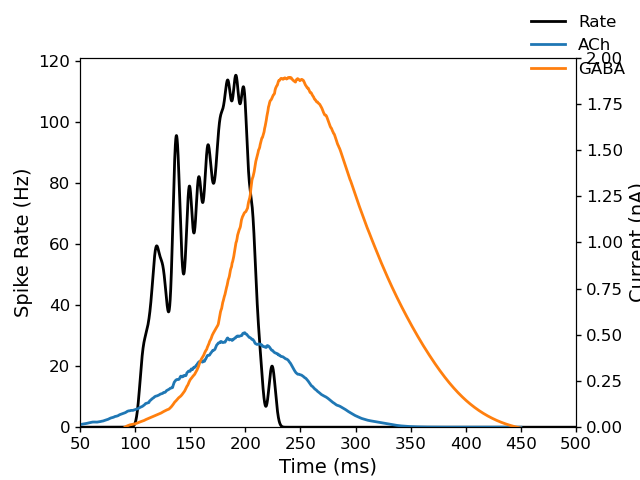

In [14]:
# same result can be seen using the non-velocity tuning dataset
offset_only_vm = np.loadtxt("/mnt/Data/PhDwork/EI_Offset/nonDirPi_dirOff/Vm.dat").T.reshape(20, 8, -1)
offset_only_vm_xaxis = np.arange(offset_only_vm.shape[-1]) * dt
offset_only_pref_rate = spike_transform(offset_only_vm[:, pref_idx], 3000, 30).mean(axis=0) * 100

if vel_idx == 1:  # only have the currents for v1000 in dir_avg_exc
    cond = "nonDirPi_dirOff"
    
    pref_rate_ach_gaba_fig, pref_rate_ach_gaba_ax = plt.subplots(1)
    ach_gaba_ax = pref_rate_ach_gaba_ax.twinx()
    ach_gaba_ax.plot(vc_xaxis, dir_avg_ach[pref_idx] * -1, linewidth=2, label="ACh")
    ach_gaba_ax.plot(vc_xaxis, dir_avg_nonds_gaba[pref_idx], linewidth=2, label="GABA")
    pref_rate_ach_gaba_ax.plot(vm_xaxis, pref_rates[cond], linewidth=2, c="black", label="Rate")
    # pref_rate_ach_gaba_ax.plot(
    #     vm_xaxis,
    #     (vm_recs[cond][vel_idx, :, pref_idx] - vm_recs[cond][vel_idx, :, pref_idx].min()).sum(axis=0),
    #     linewidth=2, c="red", label="all trials"
    # )
    # pref_rate_ach_gaba_ax.plot(offset_only_vm_xaxis, offset_only_pref_rate, linewidth=2, c="black", label="Rate")
    
    pref_rate_ach_gaba_ax.set_xlim(50, 500)
    ach_gaba_ax.set_ylim(0, 2)
    pref_rate_ach_gaba_ax.set_ylim(0)
    pref_rate_ach_gaba_ax.set_xlabel("Time (ms)", fontsize=14)
    pref_rate_ach_gaba_ax.set_ylabel("Spike Rate (Hz)", fontsize=14)
    ach_gaba_ax.set_ylabel("Current (nA)", fontsize=14)
    
    clean_axes([pref_rate_ach_gaba_ax, ach_gaba_ax], ticksize=12, remove_spines=[])
    pref_rate_ach_gaba_fig.legend(frameon=False, fontsize=12)
    pref_null_rate_fig.set_layout_engine("compressed")